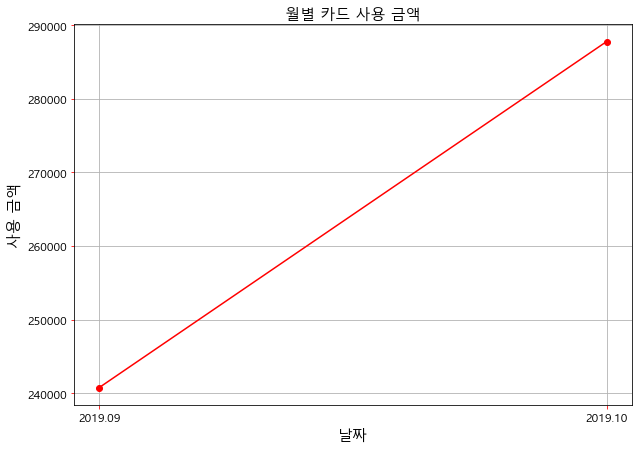

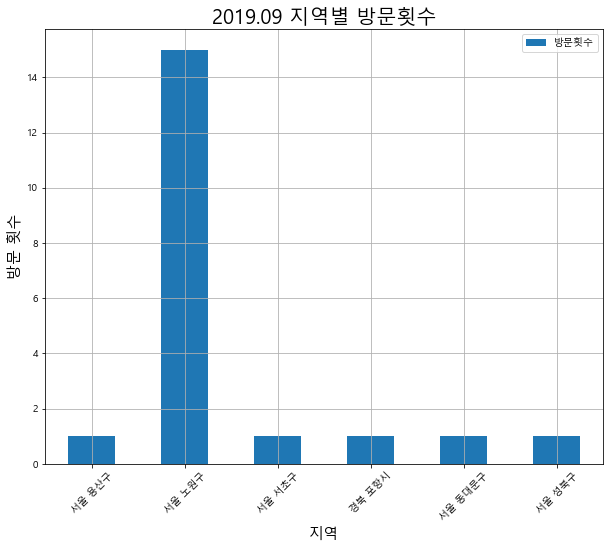

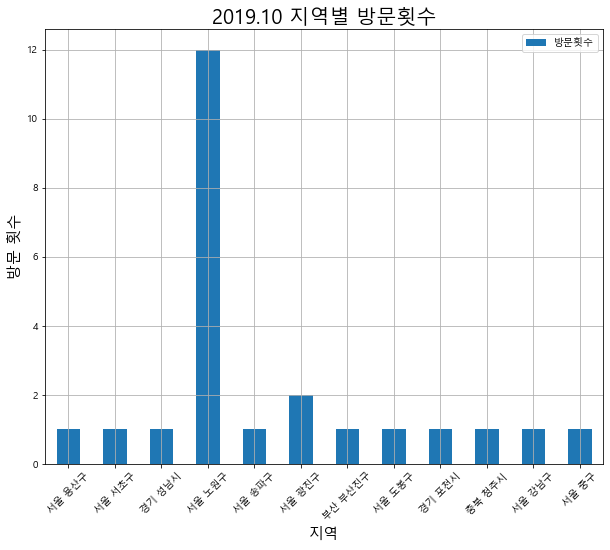

In [111]:
import pandas as pd
from bs4 import BeautifulSoup
import glob
from selenium import webdriver
import requests 
import os
import time
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

# 체크카드 명세서 자동 불러오기
receipt_data_file = glob.glob('C:/Users/again/Desktop/shinhancard/shinhancard_*.html') # 지정 폴더안에 있는 모든 파일을 불러내기 위함

# excel_writer로 보낼 data 모음
total_df = []             # 일별 DataFrame 모음
total_df_region = []      # 지역별 DataFrame 모음
List_Sum_Month_tdf = []   # 월별 합계 DataFrame 모음
sheet_nm = []             # Excel Sheet Name 모음
visit_graph = []          # 월별 방문횟수 그래프 모음

# 위의 'total_df'와 'sheet_nm'에 데이터를 삽입하기 위한 for 구문
for url in receipt_data_file :
    driver = webdriver.Chrome('c:/chromedriver.exe')
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html,'html.parser')

    title_tag = soup.select('head > title')
    title = title_tag[0].text
    
    # 암호된 문서일 경우 if 구문으로 들어감
    if title == '' :
        pw = '950730'
        driver.find_element_by_id('password').send_keys(pw)
        driver.find_element_by_xpath('//*[@id="aform"]/span/input').click()
        time.sleep(5)
        html = driver.page_source
        soup = BeautifulSoup(html,'html.parser')
        
    # 암호된 문서가 아닐 경우 아래코드로 바로 들어감
    # 명세서 데이터에서 체크 소계 제거 코드
    tables = soup.select('div#email02 > table.tblList.cardUseList > tbody > tr')
    tables_middleSum = soup.select('div#email02 > table.tblList.cardUseList > tbody > tr.middleSum')
    
    for n in range(len(tables_middleSum)) :
        tables.remove(tables_middleSum[n])
    
    # tables 데이터 string으로 변환하여 분리                      
    seperate_tables = []                        # seperate_tables 초기화
    for n in range(len(tables)) :
        table = str(tables[n].text).split('\n')
        seperate_tables = seperate_tables + table
        
    # seperate_tables에서 '사용날짜' , '사용금액', '사용처' 추출   
    date_list =  [seperate_tables[n] for n in range(1,len(seperate_tables), 12)]
    price_list = [int(seperate_tables[n].replace(',','')) for n in range(4,len(seperate_tables), 12)] 
    store_list = [seperate_tables[n].replace(" ", "") for n in range(3,len(seperate_tables), 12)]

    # seperate_tables에서 추출된 '사용처' 데이터 --> 카카오 지도 API --> '사용처'에 대한 주소 추출
    location_list = []
    def create_url(search_text):
        headers = {'Authorization': 'KakaoAK 3e8ea332f0cdef6293383ac7bf81a6fc'}
        base = "https://dapi.kakao.com/v2/local/search/keyword.json"
        param_query = "?query=" +search_text
        respond = requests.get(base + param_query,headers=headers)
        return respond.json()

    for n in range(len(store_list)) :
        store_name = store_list[n]
        result = create_url(store_name)
        tmp1 = result['documents']
        try :
            tmp2 = tmp1[0]['address_name']
            location_list.append(tmp2)
        except :
            tmp2 = np.nan
            location_list.append(tmp2)
            
    # 추출한 데이터로 DataFrame 변환
    table_data = {'사용날짜':date_list, '사용처':store_list, '사용처주소':location_list,  '사용금액':price_list }
    
    df = pd.DataFrame(table_data, index = range(1,len(date_list)+1,1), columns=['사용날짜', '사용처', '사용처주소', '사용금액'])
    df_sum = pd.DataFrame(df.sum(), columns=['합계'])
    df_total = df.append(df_sum.T)
    df_total.loc['합계', '사용날짜'] = '전체'
    df_total.loc['합계', '사용처'] = '전체'
    df_total.loc['합계', '사용처주소'] = '전체'
    total_df.append(df_total)
    List_Sum_Month_tdf.append(df_sum.T['사용금액'])    # 선그래프를 그리기 위한 합계를 List_Sum_Month_tdf=[]로 보낸다.
        
   # 월별기준 지역별 사용데이터 추출  
    df_dis_nan = df.dropna()

    df_address_list = list(df_dis_nan['사용처주소'])
    df_region_list = [ ' '.join(address.split()[:2]) for address in df_address_list]

    df_price_list = list(df_dis_nan['사용금액'])

    table_data_1 = {'사용지역':df_region_list, '사용금액':df_price_list}
    col_list = ['사용지역', '사용금액']
    df_Dup = pd.DataFrame(table_data_1 , columns = col_list ) # 중복값이 있는 df
    df_NoDup = df_Dup.drop_duplicates(subset = '사용지역')  # 중복값이 없는 df

    index_name_1 = df_Dup['사용지역']  # 중복값이 있는 사용지역 series
    df_Dup_name = df_Dup.rename(index_name_1)
    df_Dup_name = df_Dup_name.drop(['사용지역'], axis = 1)  # 중복값이 있고 사용지역이 index인 df

    index_name_2 = df_NoDup['사용지역']  # 중복값이 없는 사용지역 series
    df_NoDup_name = df_NoDup.rename(index_name_2)
    df_NoDup_name = df_NoDup_name.drop(['사용지역'], axis = 1)  # 중복값이 없고 사용지역이 index인 df

    for nm in list(index_name_2) :
        price_data = df_Dup_name.loc[nm]['사용금액']
        price_sum = price_data.sum()
        df_NoDup_name.loc[nm]['사용금액'] = price_sum

    name_region = df_Dup['사용지역']
    visit_counter = dict(name_region.value_counts())
    counter_list = []
    for k in index_name_2 :
        counter_list.append(visit_counter[k])
    
    df_NoDup_name.insert(0, '방문횟수', counter_list)
    total_df_region.append(df_NoDup_name)
    
    # 엑셀 시트네임 데이터 추출
    tables_date = soup.select('body > div.wrap.check > div.content > div.receiveDate > span.date')
    nm = str(tables_date[0].text)
    sheet_nm.append(nm)
    
    # 팝업창 닫기
    driver.close()

# 엑셀 및 이미지 저장 폴더 만들기
folder = 'C:/Users/again/Desktop/체크카드 명세서'
folder_1 = 'C:/Users/again/Desktop/체크카드 명세서/image'

if not os.path.exists(folder) :
    os.makedirs(folder)

if not os.path.exists(folder_1) :
    os.makedirs(folder_1)
    
# 월별 사용금액 데이터 시각화(엑셀 첫번째 시트에 들어감)
     
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False      
    
plt.subplots(1,1, figsize=[10,7])
plt.plot(sheet_nm, List_Sum_Month_tdf, 'o-r')

plt.xticks(rotation=360)

plt.tick_params(axis='x', labelsize=12, color='r')
plt.tick_params(axis='y', labelsize=12, color='r')

plt.xlabel('날짜', fontsize = 15)
plt.ylabel('사용 금액', fontsize = 15)
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)  # 지수 표현 방지
plt.title('월별 카드 사용 금액', fontsize = 15)

plt.grid(True)

graph_file = "C:/Users/again/Desktop/체크카드 명세서/image/mcua.png"

plt.savefig(graph_file, dpi = 200)
    
# 월별 지역 방문 횟수 데이터 시각화

for n in range(len(total_df_region)) :
    a0 = total_df_region[n][["방문횟수"]].plot.bar(grid = True, rot=45, figsize=[10,8], fontsize = 15)
    a0.set_xlabel("지역",fontsize = 15)
    a0.set_ylabel("방문 횟수",fontsize = 15)
    a0.set_title(f"{sheet_nm[n]} 지역별 방문횟수", fontsize = 20)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.xticks(rotation=45)
    visit_file = f"C:/Users/again/Desktop/체크카드 명세서/image/{sheet_nm[n]} 지역별 사용 금액.png" 
    plt.savefig(visit_file,dpi = 200)
    visit_graph.append(visit_file)

# total_df, total_df_region, sheet_nm 데이터를 활용하여 Excel로 저장
    
excel_writer = pd.ExcelWriter('C:/Users/again/Desktop/체크카드 명세서/CardUseList.xlsx', engine='xlsxwriter')

df_empty = pd.DataFrame()
df_empty.to_excel(excel_writer, index = True, sheet_name = 'Sheet1')
worksheet = excel_writer.sheets['Sheet1']
worksheet.insert_image('D2', graph_file)

ToExcel_data =[]

for n in range(len(total_df)) :
    ToAppend_total_df = total_df[n].to_excel(excel_writer, index = True, sheet_name = sheet_nm[n]+' 데이터')
    ToExcel_data.append(ToAppend_total_df)
    
    ToAppend_total_region_df = total_df_region[n].to_excel(excel_writer, index = True, sheet_name = sheet_nm[n]+' 데이터', startcol=6)
    worksheet_1 = excel_writer.sheets[sheet_nm[n]+' 데이터']
    send_worksheet_1 = worksheet_1.insert_image('K1', visit_graph[n])
    ToExcel_data.append(ToAppend_total_region_df)
    ToExcel_data.append(send_worksheet_1)

excel_writer.save()

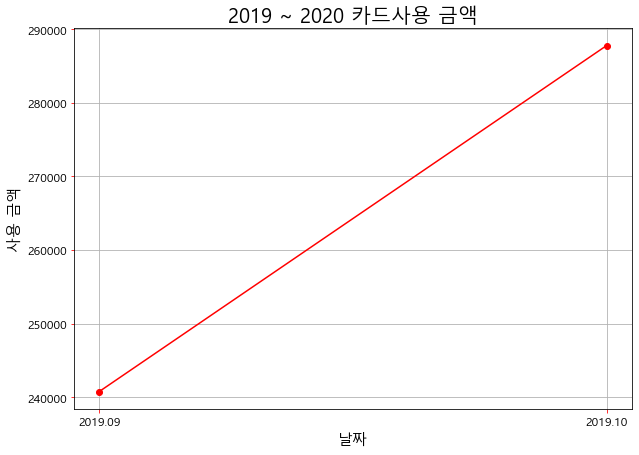

In [105]:
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False 

plt.subplots(1,1, figsize=[10,7])
plt.plot(sheet_nm, List_Sum_Month_tdf, 'o-r')

plt.xticks(rotation=360)

plt.tick_params(axis='x', labelsize=12, color='r')
plt.tick_params(axis='y', labelsize=12, color='r')

plt.xlabel('날짜', fontsize = 15)
plt.ylabel('사용 금액', fontsize = 15)
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)  # 지수 표현 방지

plt.title('2019 ~ 2020 카드사용 금액', fontsize = 20)

plt.grid(True)

graph_file = "C:/Users/again/Desktop/체크카드 명세서/월별 카드 사용 금액.png"

plt.savefig(graph_file, dpi = 200)

plt.show()

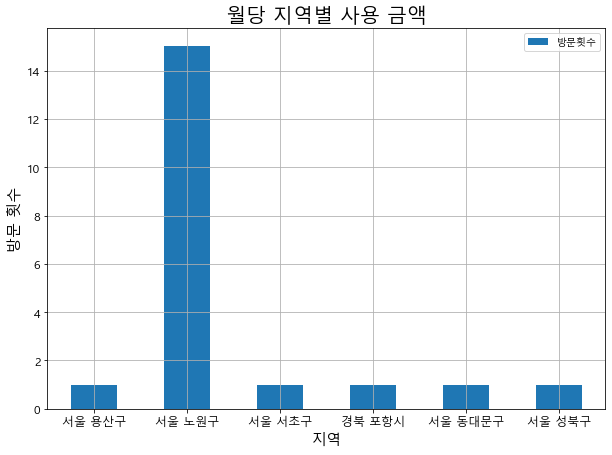

In [106]:
a0=total_df_region[0][["방문횟수"]].plot.bar(grid = True, rot=45, figsize=[10,7], fontsize = 15)
a0.set_xlabel("지역", fontsize = 15)
a0.set_ylabel("방문 횟수", fontsize = 15)
a0.set_title("월당 지역별 사용 금액", fontsize = 20)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=360)

plt.savefig("C:/Users/again/Desktop/체크카드 명세서/월당 지역별 사용 금액0.png", dpi = 200)

plt.show()

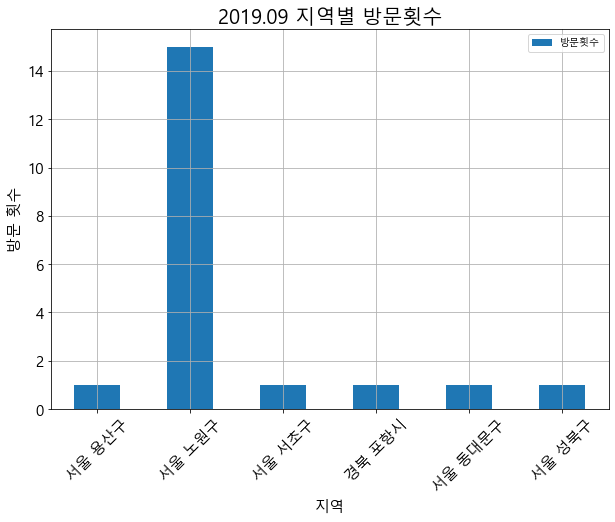

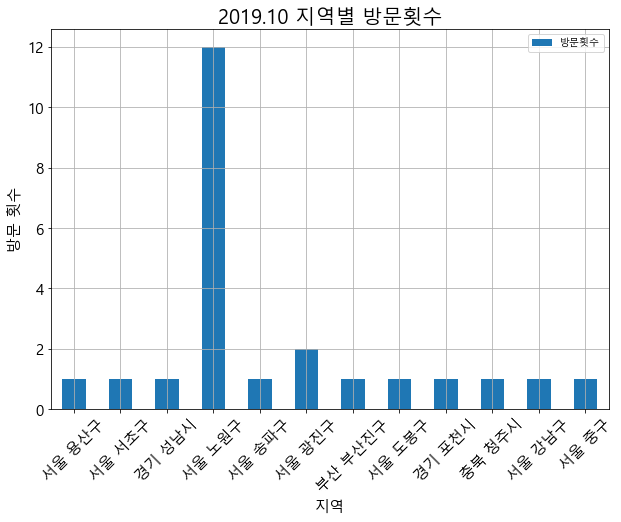

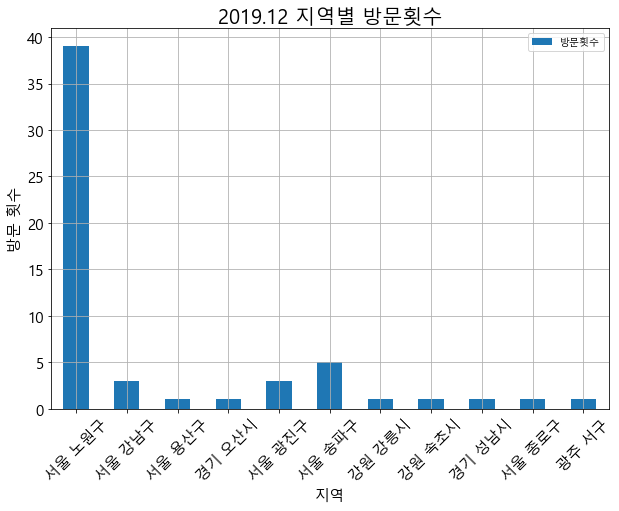

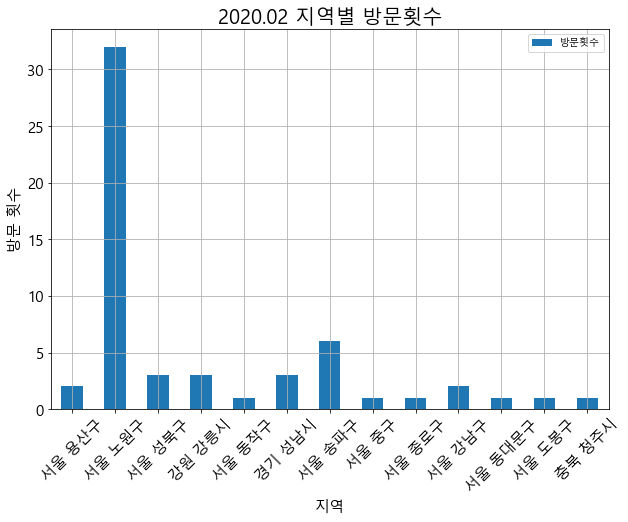

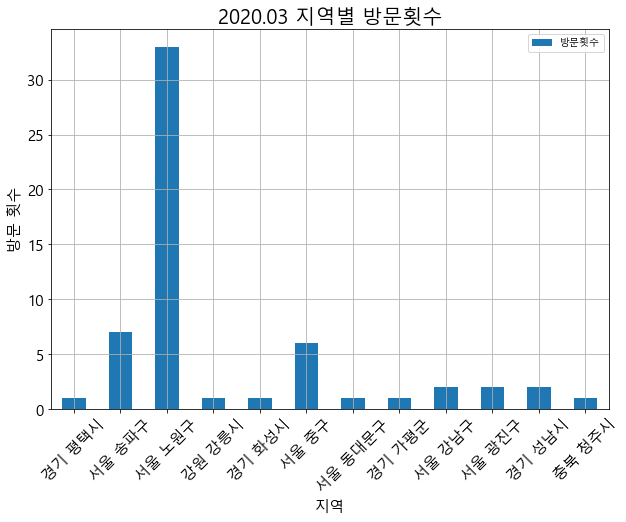

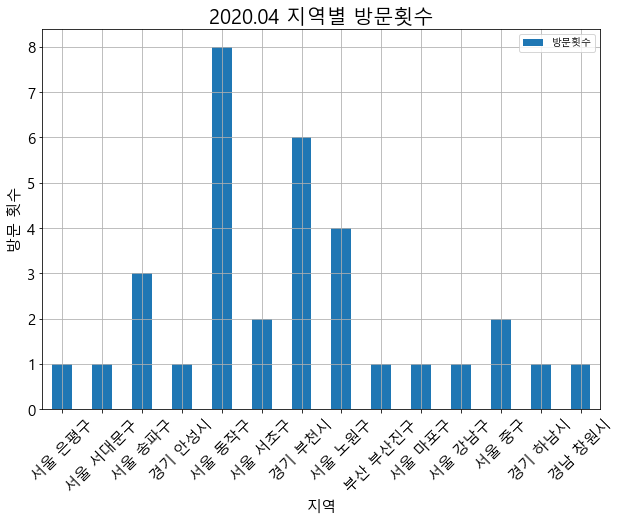

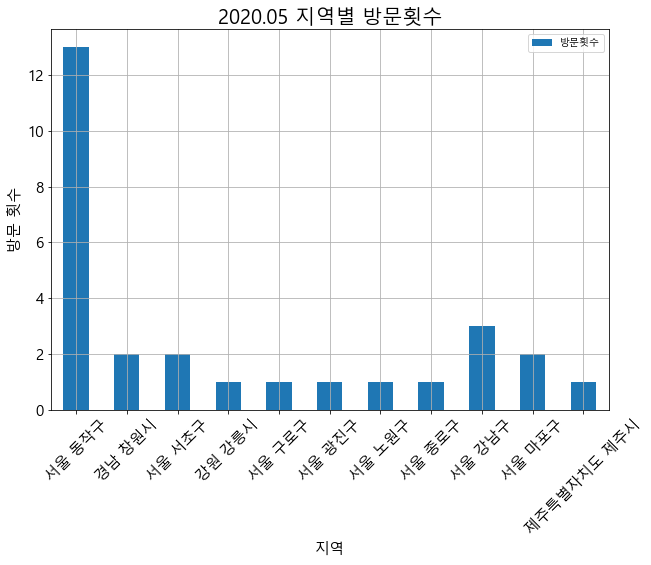

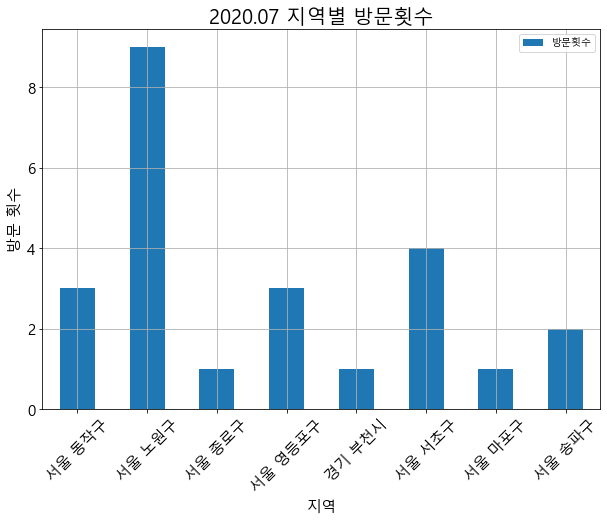

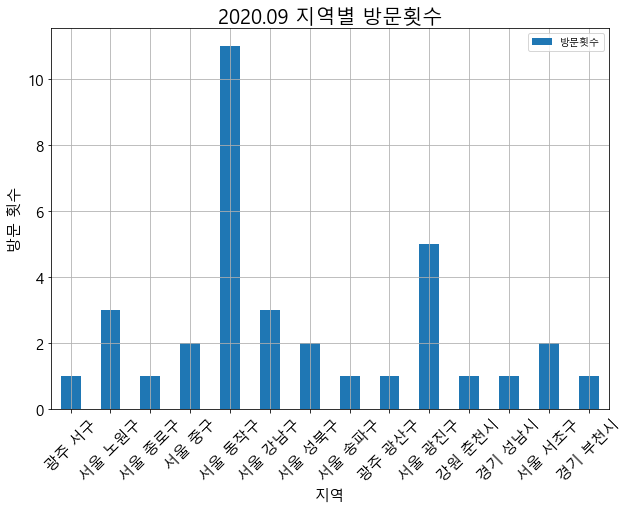

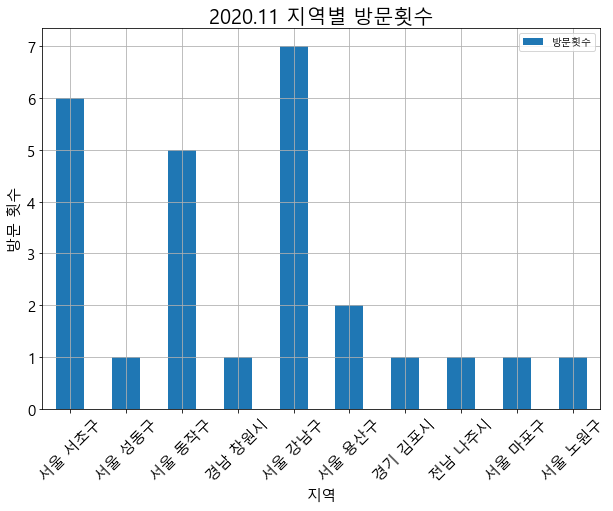

In [79]:
visit_graph=[]

for n in range(len(total_df_region)) :
    a0 = total_df_region[n][["방문횟수"]].plot.bar(grid = True, rot=45, figsize=[10,7], fontsize = 15)
    a0.set_xlabel("지역",fontsize = 15)
    a0.set_ylabel("방문 횟수",fontsize = 15)
    a0.set_title(f"{sheet_nm[n]} 지역별 방문횟수", fontsize = 20)
    plt.xticks(rotation=45)
    visit_file = f"C:/Users/again/Desktop/체크카드 명세서/{sheet_nm[n]} 지역별 사용 금액.png" 
    plt.savefig(visit_file,dpi = 200)
    visit_graph.append(visit_file)

In [ ]:
List_Sum_region_tdf=[]

In [100]:
total_df_region[0]

,방문횟수,사용금액
서울 용산구,1,1000
서울 노원구,15,61810
서울 서초구,1,66000
경북 포항시,1,6000
서울 동대문구,1,3000
서울 성북구,1,5800
